In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import astropy
from astropy.io import fits
import pandas as pd
from astropy.time import Time

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

print('Numpy version ', np.__version__)
print('Pandas version ',pd.__version__)
print('Astropy version ', astropy.__version__)

Numpy version  1.21.5
Pandas version  1.4.4
Astropy version  5.1


In [4]:
##Fuctions
def normal_(wave, I, point): #For nomalizing the spectra
    dff = wave-point
    order = list(abs(dff)).index(min(abs(dff)))
    value = np.nanmedian(I[order-10:order:10])
    return value

## How we make the combined solar analog spectra

Let us show you how we combine the solar analog.

Text(0, 0.5, 'Normalized reflectance')

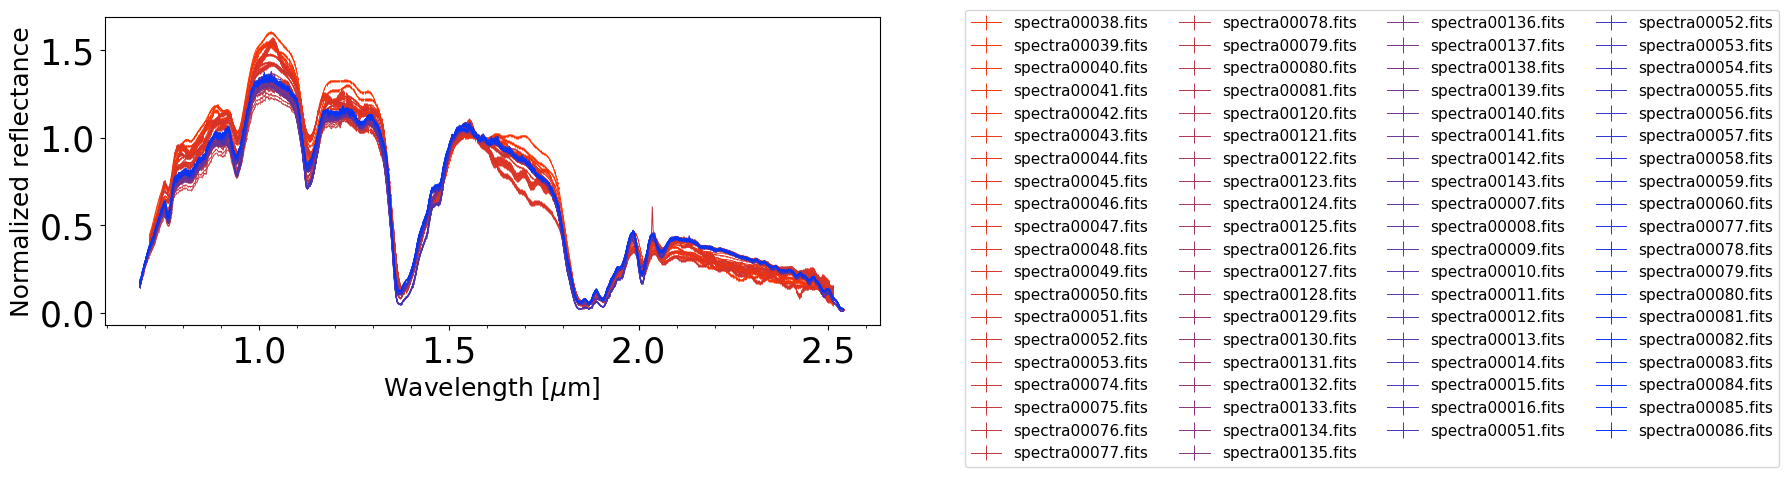

In [10]:
##1. Bring the solar analog spectra
sol_name = 'SAO_42382'
dic_sol = os.path.join('/Users/judy/Dropbox/Research/SpeX/230205/proc/SAO_42382')
#Directory where the only 1D-solar analog spectra in FITS format are saved
file_sol = glob.glob(os.path.join(dic_sol,'spec*.fits'))
file_sol5 = sorted(file_sol)

dic_sol = os.path.join('/Users/judy/Dropbox/Research/SpeX/230206/proc/SAO_42382')
#Directory where the only 1D-solar analog spectra in FITS format are saved
file_sol = glob.glob(os.path.join(dic_sol,'spec*.fits'))
file_sol6 = sorted(file_sol)



#Plot the all spectra together
file_sol = np.concatenate([file_sol5, file_sol6])
fig,ax = plt.subplots(1,1,figsize=(10,4))
array = []
for n,file in enumerate(file_sol):
    hdul = fits.open(file)[0]
    header = hdul.header
    data = hdul.data
    name = file.split('/')[-1]
    r = 1/len(file_sol)*(len(file_sol)-n)
    b = 1/len(file_sol)*(n)
    color=(r, 0.2, b)
    
    nor = normal_(data[0],data[1],1.6)
    ax.errorbar(data[0],data[1]/nor,yerr=data[2]/nor,color=color,
               lw=0.7,label=name)
    array.append(data[1]/nor)
ax.legend(fontsize=11,bbox_to_anchor=(1.1, 1.05),ncol=4)
ax.tick_params(axis='both',labelsize=25)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlabel(r'Wavelength [$\mu$m]',fontsize=18)
ax.set_ylabel('Normalized reflectance',fontsize=18)


### Sort out the suspicious spectra due to bad weather
1. Divide all indiviual spectra by the median combined spectrum. 
2. Check if the divied spectrum are roughly flat or not. 
3. If the spectra is not flat (i.e., has a slope), we consider that the spectrum is suspicious.
4. Check the log file and the weather when the suspicious spectrum was taken.
5. Exclude the suspicious spectrum if the weather was not good when the spectrum was taken. 
6. Re-derive the median combined spectrum

By this way, we exclude the spectra taken from 2023 Feb 05 08:39~09:07 (UT).<br />
Indeed, the weather when these spectra are measured was not good. There was the low thick cloud.

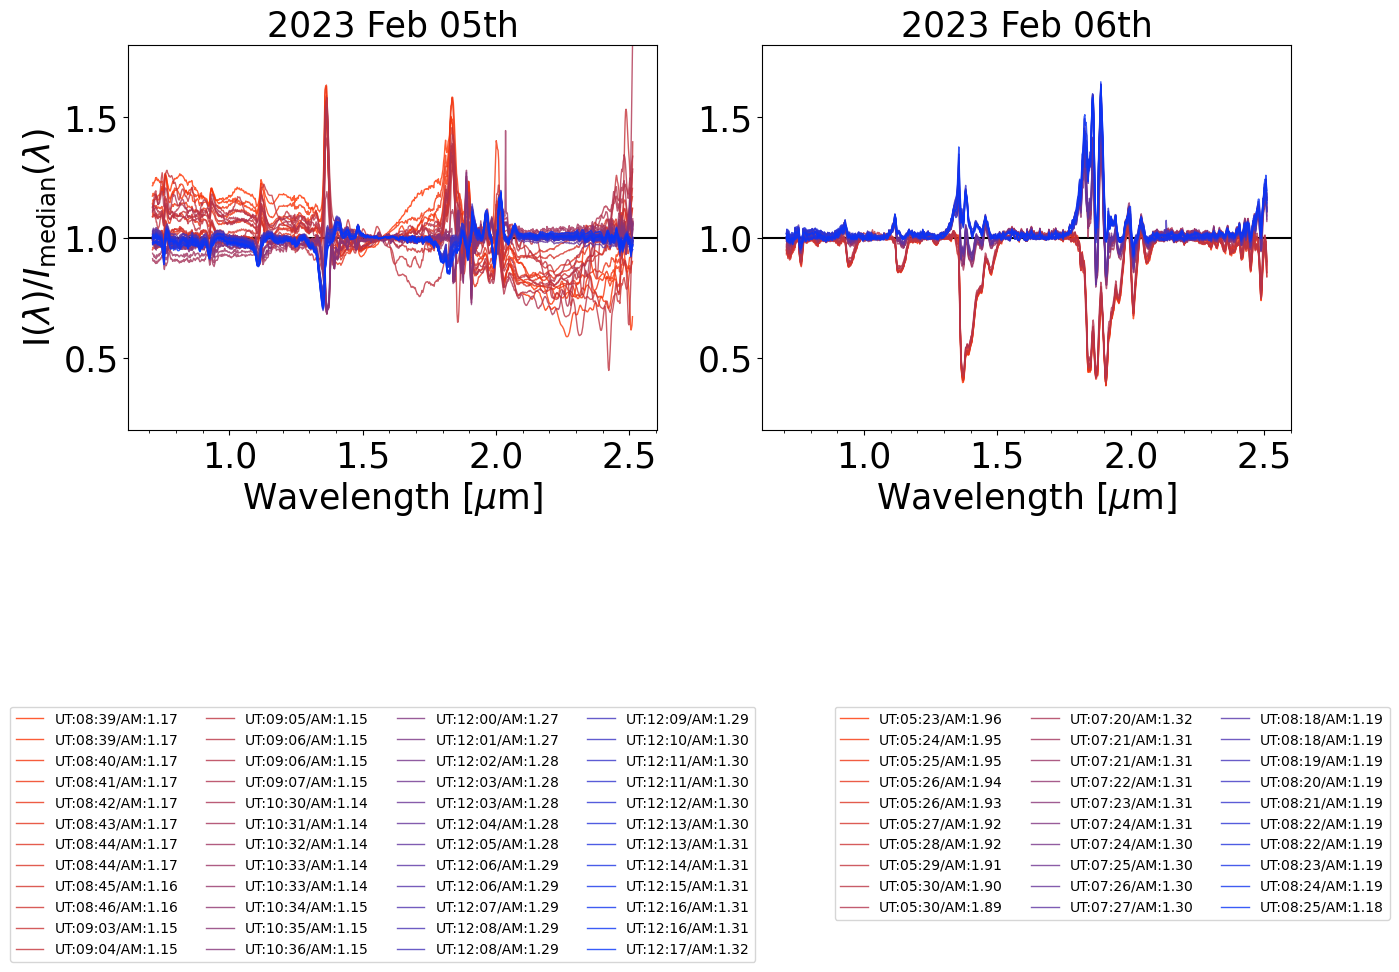

In [11]:
#Make the median combined spectrum
array = []
for n,file in enumerate(np.concatenate([file_sol5, file_sol6])):
    hdul = fits.open(file)[0]
    header = hdul.header
    data = hdul.data
    name = file.split('/')[-1]
    nor = normal_(data[0],data[1],1.6)
    array.append(data[1]/nor)
array_med = np.median(array, axis=0)


#Plot the individual spectra/the median combined spectrum
fig,ax = plt.subplots(1,2,figsize=(15,5))
for n,file in enumerate(file_sol5):
    hdul = fits.open(file)[0]
    header = hdul.header
    data = hdul.data
    
    nor_med = normal_(data[0],array_med,1.6)
    array_med_ = array_med/nor_med
    name = 'UT:'+header['TIME_OBS'][:5] + '/AM:{0:.2f}'.format(header['TCS_AM'])
    r = 1/len(file_sol5)*(len(file_sol5)-n)
    b = 1/len(file_sol5)*(n)
    color=(r, 0.2, b)
    
    nor = normal_(data[0],data[1],1.6)
    I_ = data[1]/nor
    
    residual = I_/array_med_
    ax[0].errorbar(data[0],residual,color=color,alpha=0.8,
               lw=1,label=name)
    
    
for n,file in enumerate(file_sol6):
    hdul = fits.open(file)[0]
    header = hdul.header
    data = hdul.data
    
    nor_med = normal_(data[0],array_med,1.6)
    array_med_ = array_med/nor_med
    name = 'UT:'+header['TIME_OBS'][:5] + '/AM:{0:.2f}'.format(header['TCS_AM'])
    r = 1/len(file_sol6)*(len(file_sol6)-n)
    b = 1/len(file_sol6)*(n)
    color=(r, 0.2, b)
    
    nor = normal_(data[0],data[1],1.6)
    I_ = data[1]/nor
    
    residual = I_/array_med_
    ax[1].errorbar(data[0],residual,color=color,alpha=0.8,
               lw=1,label=name)   
for i in [0,1]:    
    ax[i].set_ylim(0.2,1.8)
    ax[i].axhline(1, color='k')
    ax[i].tick_params(axis='both',labelsize=25)
    ax[i].xaxis.set_major_locator(MultipleLocator(0.5))
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.1))
    ax[i].set_xlabel(r'Wavelength [$\mu$m]',fontsize=25)
ax[0].set_ylabel(r'I($\lambda$)/$I_\mathrm{median}(\lambda)$',fontsize=25)
ax[0].set_title('2023 Feb 05th', fontsize=25)
ax[1].set_title('2023 Feb 06th', fontsize=25)
ax[0].legend(fontsize=10,ncol=4,bbox_to_anchor=(1.2, -0.7))    
ax[1].legend(fontsize=10,ncol=3,bbox_to_anchor=(1.2, -0.7))    


### Combining the spec depending on the airmass
The combined spectra in this step will be used to process the asteroidal spectra.<br />
Let us show how we combine the spectra taken on 2023 Feb 06, as the example.

We do the median combine of spectra.<br />
The value at each pixel (i.e., wavelength) is given by the median,.<br />
and their uncertainty is given by the standard error around the median (MAD/$\sqrt(N)$) of the pixels.<br />
Here, MAD is the median absolute deviation given by 1.482 × med(|I($\lambda$) − med(I($\lambda$))|), and N= number of spectra. .<br />
We followed the SpexTool manual, section 2.8 Combination Statistics (page 16).

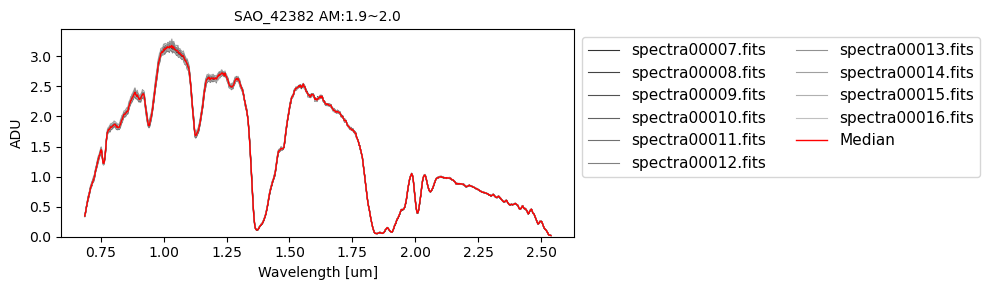

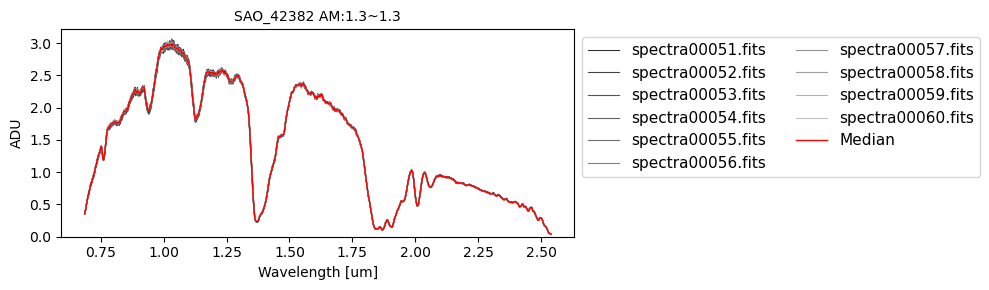

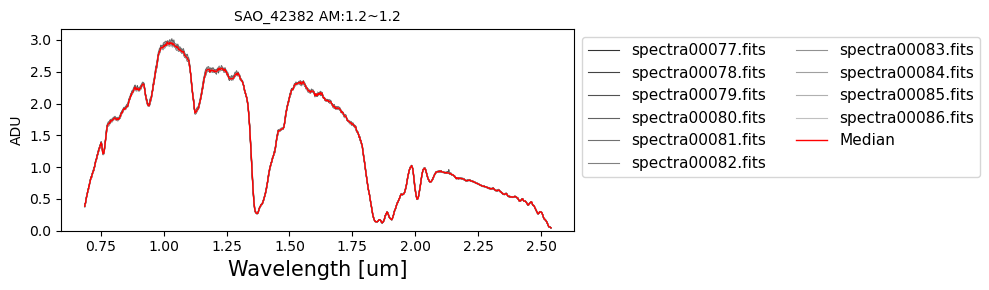

In [25]:
com_spec = pd.DataFrame({'filename':[],'wave':[],'spec':[],'err':[]})
num_pre = int(file_sol6[0].split('spectra0')[-1].split('.fits')[0])
for n,file in enumerate(file_sol6):
    #Bring the fits file
    hdul = fits.open(file)[0]
    header = hdul.header
    data = hdul.data
    OBJECT = header['OBJECT']
    
    '''
    We use the number in the fits file name (i.e., spectra000XX.fits, where XX is the number we used)
    We consider the spectra to be taken at the same airmass if they were taken consecutively.
    '''
    num = int(file.split('spectra0')[-1].split('.fits')[0])
    filename = file.split('/')[-1]
    if num - num_pre <2 : 
        #These spectra are taken consecutively
        com_spec = com_spec.append({'filename':filename,
                                   'wave':data[0],
                                   'spec':np.array(data[1])/np.nanmedian(np.array(data[1])),
                                   'err':data[2]/np.nanmedian(np.array(data[1])),
                                   'AIRMASS':header['TCS_AM']},
                                  ignore_index=True)
        
    elif num - num_pre >2 or n == len(file_sol6)-1:
        #These spectra are "not" taken consecutively.
        fig,ax = plt.subplots(1,1,figsize=(10,3))
        for k in range(len(com_spec)):
            r = 1/len(com_spec)*(k/1.3)
            b = 1/len(com_spec)*(k)
            color=(r, 0.0, b)
            ax.errorbar(com_spec['wave'][k],
                        com_spec['spec'][k],
                        color=str(r),label=com_spec['filename'][k],
                       lw=0.8,alpha=0.8)
        med = np.median(list(com_spec['spec'].values), axis=0)
        err_tem = []
        for l in range(len(com_spec['spec'].values)):
            sub_array = abs(com_spec['spec'].values[l]-med)
            err_tem.append(sub_array)
        MAD = 1.482*np.median(err_tem,axis=0)
        err_med = MAD/np.sqrt(len(com_spec['spec'].values))
        ax.errorbar(com_spec['wave'][k],
                    med,
                    yerr=err_med,
                    ecolor='w',
                    color='r',label='Median',
                    lw=1)
        ax.legend(fontsize=11,ncol=2,bbox_to_anchor=(1, 1))    
        ax.set_xlabel('Wavelength [um]',fontsize=10)
        ax.set_ylabel('ADU')
        ax.set_ylim(0,)
        ax.set_title(OBJECT+' AM:{0:.1f}~{1:.1f}'.format(min(com_spec['AIRMASS'].values),
                                                         max(com_spec['AIRMASS'].values)),fontsize=10)
        plt.tight_layout()
        new = os.path.join(dic_sol,'com_'+OBJECT
                           +'_AIRMASS_{0:.3f}.fits'.format(np.mean(com_spec['AIRMASS'])))
        header['COMMENT']='Total {2} files combined:{0}~{1}'.format(
            com_spec['filename'].values[0],
            com_spec['filename'].values[-1],
            len(com_spec))
        new_data = []
        new_data.append(com_spec['wave'][k])
        new_data.append(med)
        new_data.append(err_med)
        plt.show()
        com_spec = pd.DataFrame({'filename':[],'wave':[],'spec':[],'err':[]})
        com_spec = com_spec.append({'filename':filename,
                                   'wave':data[0],
                                   'spec':np.array(data[1])/np.nanmedian(np.array(data[1])),
                                   'err':data[2]/np.nanmedian(np.array(data[1])),
                                   'AIRMASS':header['TCS_AM']},
                                  ignore_index=True)
    num_pre = num 
        
    
fig,ax = plt.subplots(1,1,figsize=(10,3))
for k in range(len(com_spec)):
    r = 1/len(com_spec)*(k/1.3)
    b = 1/len(com_spec)*(k)
    color=(r, 0.0, b)
    ax.errorbar(com_spec['wave'][k],
                com_spec['spec'][k],
                color=str(r),label=com_spec['filename'][k],
               lw=0.8,alpha=0.8)
med = np.median(list(com_spec['spec'].values), axis=0)
err_med = np.sqrt(np.sum(com_spec['err']**2,axis=0))/len(com_spec['err'])
ax.errorbar(com_spec['wave'][k], med,
            yerr=err_med,
            ecolor='w',color='r',
            label='Median',lw=1)
ax.legend(fontsize=11,ncol=2,bbox_to_anchor=(1, 1))    
ax.set_xlabel('Wavelength [um]',fontsize=15)
ax.set_ylabel('ADU')
ax.set_ylim(0,)
ax.set_title(OBJECT+' AM:{0:.1f}~{1:.1f}'.format(min(com_spec['AIRMASS'].values),
                                                 max(com_spec['AIRMASS'].values)),fontsize=10)
plt.tight_layout()

new = os.path.join(dic_sol,
                   'com_'+OBJECT
                   +'_AIRMASS_{0:.3f}.fits'.format(np.mean(com_spec['AIRMASS'])))
header['COMMENT']='Total {2} files combined:{0}~{1}'.format(
    com_spec['filename'].values[0],
    com_spec['filename'].values[-1],
    len(com_spec))
new_data = []
new_data.append(com_spec['wave'][k])
new_data.append(med)
new_data.append(err_med)
#Save the combined solar analog spectrum
#This spectrum will be used to process the asteroidal spectra.
fits.writeto(os.path.join(dic_sol,new),new_data,header,overwrite=True) 
